In [189]:
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
from esda.moran import Moran_Local
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import glob
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [191]:
def load_local():
    return pd.read_csv('data/df_house.csv')

def load_zone_value():
    zone_value = gpd.read_file('data/ZonaNilaiTanah.shp')
    zone_value = zone_value[zone_value['KABKOT'].str.contains('Jakarta', na=False)]
    return zone_value

def load_adm():
    adm = gpd.read_file('data/kelurahan_jakarta_dukcapil.gpkg')
    adm = adm[['giskemendagri.gisadmin.Kelurahan_2020Sem2.nama_prop_', 
                'giskemendagri.gisadmin.Kelurahan_2020Sem2.nama_kab_s', 
                'giskemendagri.gisadmin.Kelurahan_2020Sem2.nama_kec_s', 
                'giskemendagri.gisadmin.Kelurahan_2020Sem2.nama_kel_s',
                'geometry']]
    adm.columns = ['provinsi', 'kabupaten','kecamatan','kelurahan','geometry']
    adm['key'] = adm.apply(lambda x:x['provinsi']+'-'+x['kabupaten']+'-'+x['kecamatan']+'-'+x['kelurahan'], axis = 1)

    return adm

def clean_outlier(df, variable):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    upper_limit = q3 + 1.5*iqr
    lower_limit = q1 - 1.5*iqr

    print(f'IQR {iqr.round(2)}')

    print(f'Upper limit {upper_limit.round(2)}')
    print(f'Lower limit {lower_limit.round(2)}')

    print(f"shape before cleaning {df.shape}")
    df_clean = df[(df[variable]>=lower_limit) & (df[variable]<=upper_limit)]
    print(f"shape after cleaning {df_clean.shape}")
    return df_clean

def load_data_pipeline():
    df_house = load_local()
    df_house['price_per_meter'] = df_house['price']/df_house['land_size']
    df_house = df_house[df_house['price_per_meter']!=np.inf]
    df_house = df_house[df_house['price_per_meter']>0]
    df_house = clean_outlier(df_house, 'price_per_meter')

    gdf = gpd.GeoDataFrame(
        df_house, geometry=gpd.points_from_xy(df_house.longitude, df_house.latitude), crs="EPSG:4326"
    )

    adm = load_adm()

    # zone_value = load_zone_value()

    return df_house, gdf, adm

In [192]:
df_house, gdf, adm = load_data_pipeline()

IQR 17857142.86
Upper limit 64285714.29
Lower limit -7142857.14
shape before cleaning (7122, 13)
shape after cleaning (6711, 13)


# Price Distribution

(0.0, 5000000000.0)

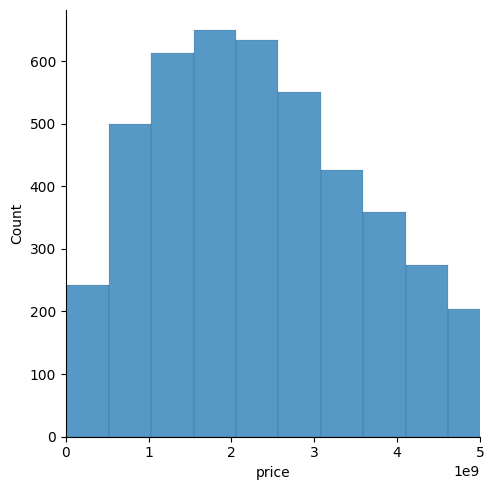

In [193]:
sns.displot(df_house['price'])
plt.xlim(0,5000000000)

# Data Preprocessing

In [194]:
def get_adm_summary():
    df = gdf.sjoin(zone_value).drop('index_right', axis = 1)
    df = df.sjoin(adm).drop('index_right', axis = 1)
    df = df.rename(columns = {'key_right':'adm_key'})

    df_house_agg = df.groupby('adm_key')['price_per_meter'].median().reset_index()

    return df_house_agg

def get_area_summary():
    df_house_agg = get_adm_summary()
    area_summary = pd.merge(adm, df_house_agg, left_on='key', right_on = 'adm_key').drop('key', axis = 1)
    area_summary = area_summary[area_summary['adm_key'].str.contains('JAKARTA')]

    return area_summary

In [195]:
area_summary = get_area_summary()

Text(0.5, 1.0, 'Price per Meter Plot')

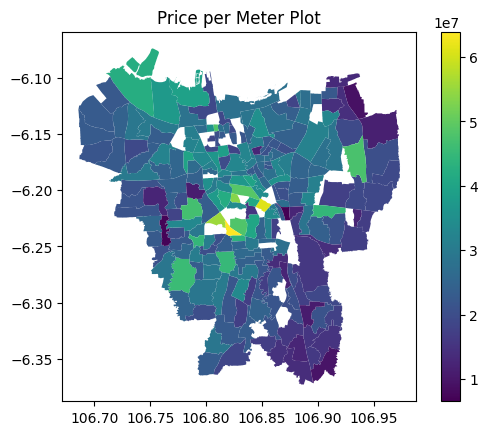

In [196]:
area_summary.plot('price_per_meter', legend = True)
plt.title('Price per Meter Plot')

# Global Moran

In [197]:
def calculate_global_moran(df, variable):
    gdf = df.copy()

    # Drop rows with missing values in the chosen variable
    gdf = gdf.dropna(subset=[variable])

    # Create spatial weights (e.g., Queen contiguity)
    w = Queen.from_dataframe(gdf)
    w.transform = "r"  # Row-standardization for weights

    # Calculate global Moran's I
    moran = Moran(gdf[variable], w)
    print("Global Moran's I:", moran.I)
    print("p-value:", moran.p_sim)


In [198]:
calculate_global_moran(gdf, 'price_per_meter')

Global Moran's I: 0.3536932888311157
p-value: 0.001


# Local Moran

In [199]:
def get_lisa_cluster(df, variable):
    # Load your GeoDataFrame
    gdf = df.copy()

    # Step 1: Standardize the variable
    gdf['z_variable'] = (gdf[variable] - gdf[variable].mean()) / gdf[variable].std()

    # Step 2: Create a spatial weights matrix
    w = Queen.from_dataframe(gdf)
    w.transform = 'r'  # Row-standardize weights

    # Step 3: Compute the spatial lag of the standardized variable
    gdf['spatial_lag'] = np.array([
        np.sum(np.array(list(w[row].values())) * gdf.loc[list(w[row].keys()), 'z_variable'].values)
        for row in gdf.index
    ])

    # Step 4: Perform Local Moran's I Analysis
    moran_local = Moran_Local(gdf['z_variable'], w)

    # Add LISA statistic and p-value to the GeoDataFrame
    gdf['LISA_stat'] = moran_local.Is  # Local Moran's I statistic
    gdf['p_value'] = moran_local.p_sim  # P-value from permutations

    # Step 5: Classify LISA clusters based on the quadrants
    def classify_lisa(row):
        if row['z_variable'] > 0 and row['spatial_lag'] > 0:
            return 'High-High'
        elif row['z_variable'] < 0 and row['spatial_lag'] > 0:
            return 'Low-High'
        elif row['z_variable'] > 0 and row['spatial_lag'] < 0:
            return 'High-Low'
        else:
            return 'Low-Low'

    # Add LISA cluster classification to the GeoDataFrame
    gdf['LISA_cluster'] = gdf.apply(classify_lisa, axis=1)

    return gdf

def plot_moran_scatter(gdf):
    # Step 5: Moran Scatter Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(gdf['z_variable'], gdf['spatial_lag'], alpha=0.6, edgecolor='k')

    # Add quadrant lines
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')

    # Label the quadrants
    ax.text(1.5, 1.0, "HH (High-High)", fontsize=12, color="red")
    ax.text(-1.5, 1.0, "LH (Low-High)", fontsize=12, color="blue")
    ax.text(1.5, -1.0, "HL (High-Low)", fontsize=12, color="green")
    ax.text(-1.5, -1.0, "LL (Low-Low)", fontsize=12, color="purple")

    # Set labels and title
    ax.set_title("Moran Scatter Plot", fontsize=16)
    ax.set_xlabel("Standardized Variable (z-score)", fontsize=14)
    ax.set_ylabel("Spatial Lag (Weighted Average)", fontsize=14)

    plt.show()

def plot_cluster(gdf, significant = False):
    df_plot = gdf.copy()
    if significant:
        df_plot['LISA_cluster'] = df_plot[['p_value','LISA_cluster']].apply(lambda x:x[1] if x[0]<0.05 else 'Insignificant', axis = 1)
    else:
        pass
    
    # Plot Local Moran's I clusters
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    df_plot.plot(
        column='LISA_cluster',
        cmap='coolwarm',
        legend=True,
        # color=gdf['lisa_cluster_label'].map(cluster_cmap),
        # legend_kwds={'title': 'LISA Cluster'},
        ax=ax
    )
    plt.title("LISA Clusters")
    plt.show()

def get_city_summary(df):
    city_summary = df.groupby(['kabupaten','LISA_cluster'])['adm_key'].count().reset_index().pivot(index = 'kabupaten', columns = 'LISA_cluster', values = 'adm_key')
    city_summary['total'] = city_summary.sum(axis = 1)
    for col in city_summary.columns[:-1]:
        city_summary[col] = city_summary[col]/city_summary['total']

    city_summary.drop('total', axis = 1, inplace = True)
    city_summary = city_summary*100
    city_summary = city_summary.round(2)

    return city_summary

def plot_count_area(df):
    plot = df.stack().reset_index()

    # Define a colormap for the categorical variable
    cmap = ListedColormap(sns.color_palette("coolwarm", len(plot['LISA_cluster'].unique())).as_hex())
    group_colors = dict(zip(plot['LISA_cluster'].unique(), cmap.colors))

    # Map the colors to the 'group' column
    plot['color'] = plot['LISA_cluster'].map(group_colors)

    colors = plot['color'].tolist()

    plt.figure(figsize = (15,8))
    sns.barplot(data = plot, 
                x = 'kabupaten', 
                y = 0, 
                hue = 'LISA_cluster', 
                palette=colors)

    # Add labels and title
    plt.title('Percentage of LISA Cluster by Area', fontsize=16)
    plt.xlabel('Category', fontsize=14)
    plt.ylabel('Value(%)', fontsize=14)

    plt.show()

In [200]:
gdf_agg = get_lisa_cluster(area_summary, 'price_per_meter')
city_summary = get_city_summary(gdf_agg)

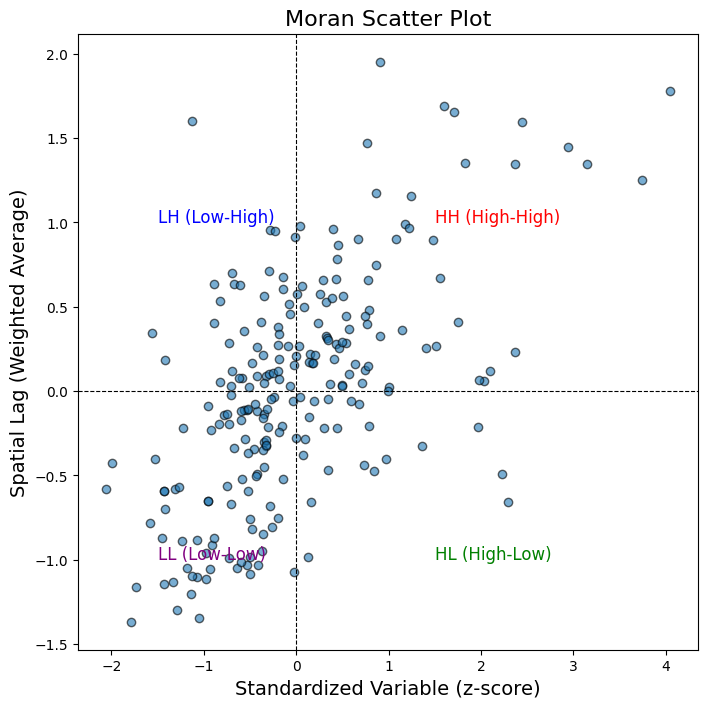

In [201]:
plot_moran_scatter(gdf_agg)

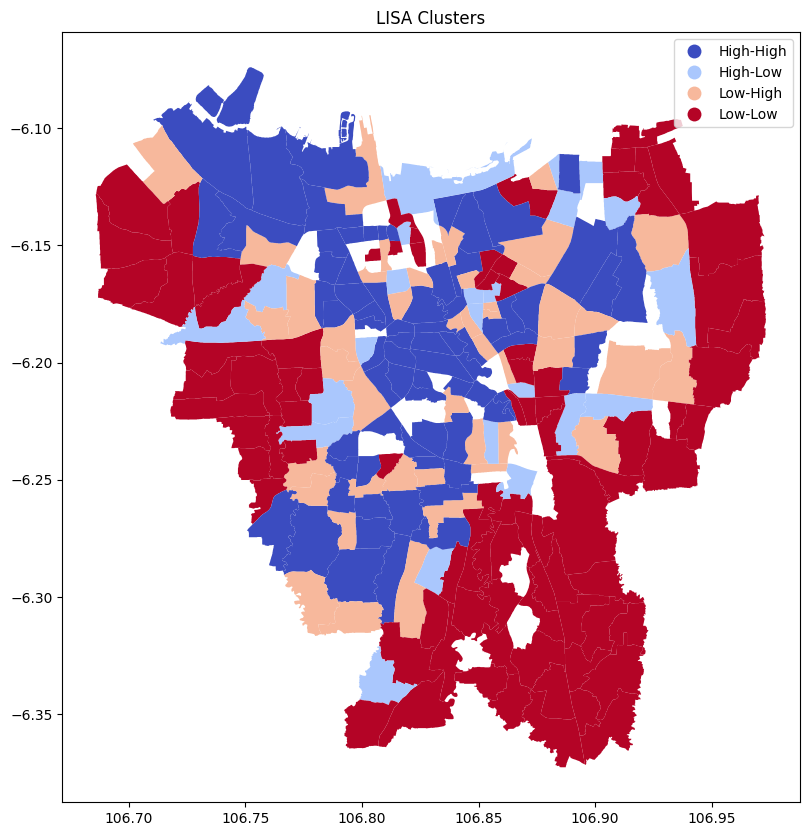

In [202]:
plot_cluster(gdf_agg, significant = False)

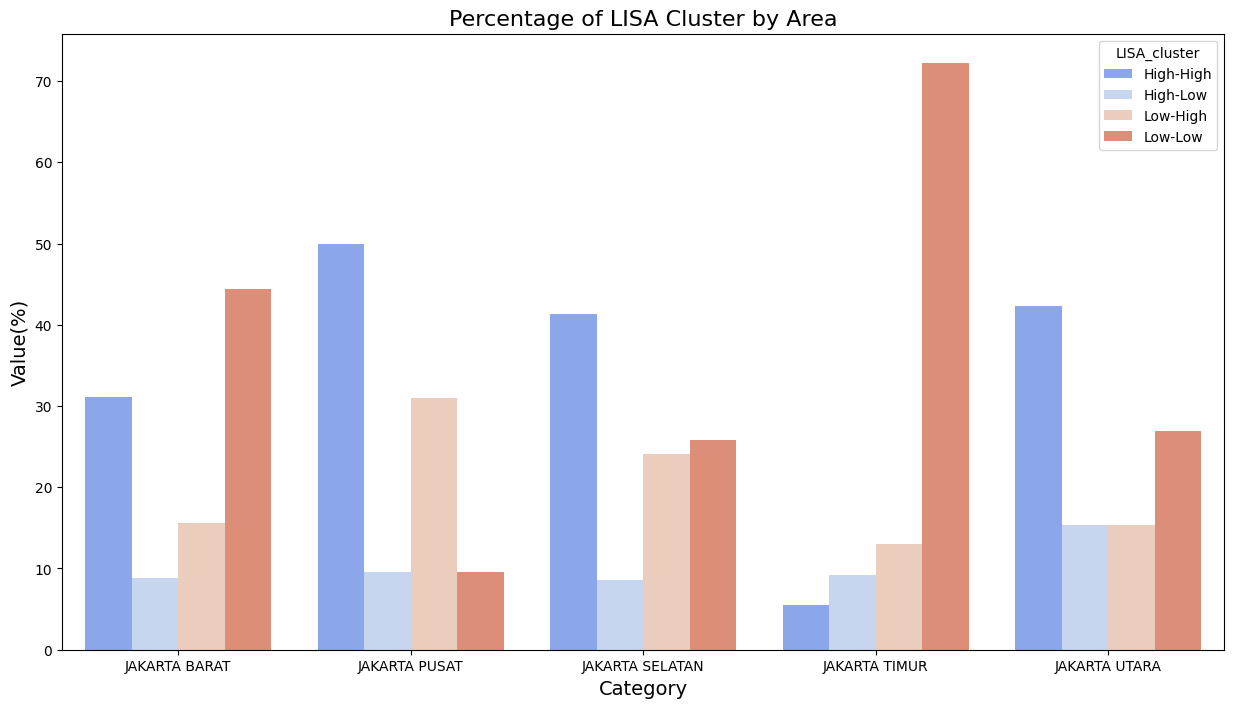

In [203]:
plot_count_area(city_summary)

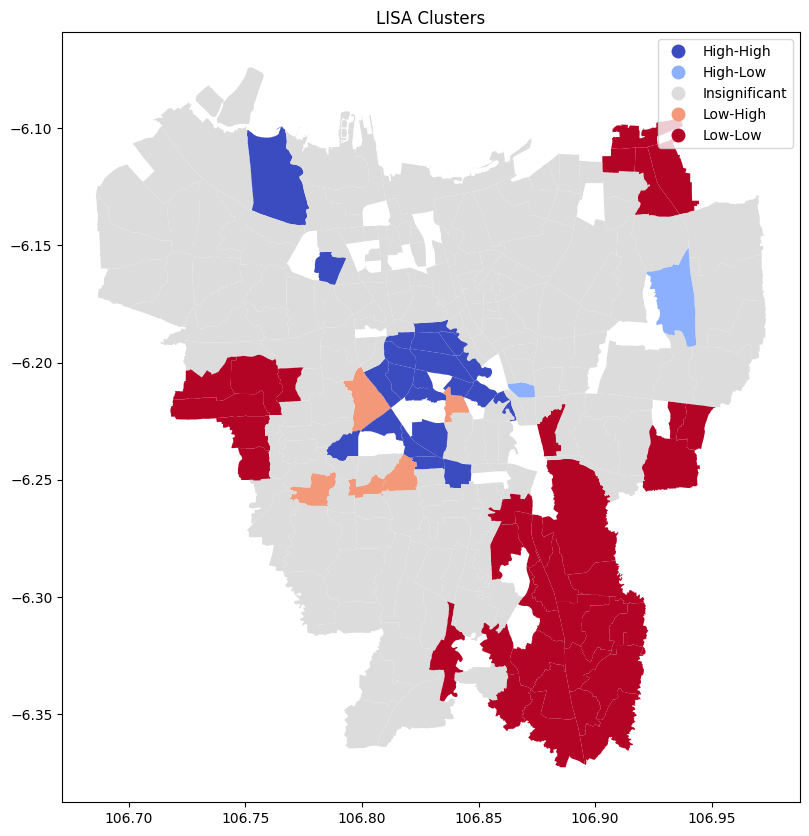

In [204]:
plot_cluster(gdf_agg, significant = True)

# Price Boxplot

<Axes: xlabel='price', ylabel='adm_key'>

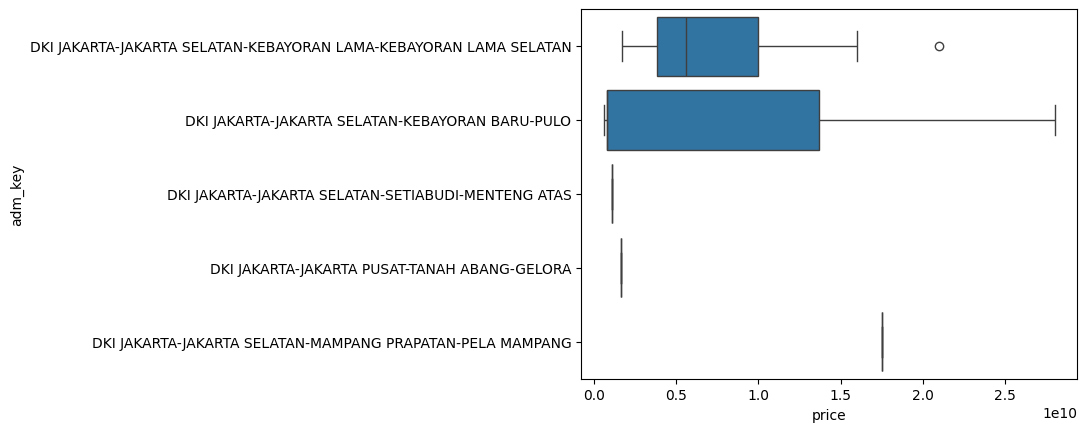

In [205]:
potential = gdf_agg[(gdf_agg['LISA_cluster']=='Low-High')&(gdf_agg['p_value']<0.05)][['geometry', 'adm_key']]
gdf_filtered = gdf.sjoin(potential)
sns.boxplot(data = gdf_filtered,x = 'price', y = 'adm_key')